![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt




In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:title={'center':'Sentiminetos por aerolínea'}, xlabel='airline'>

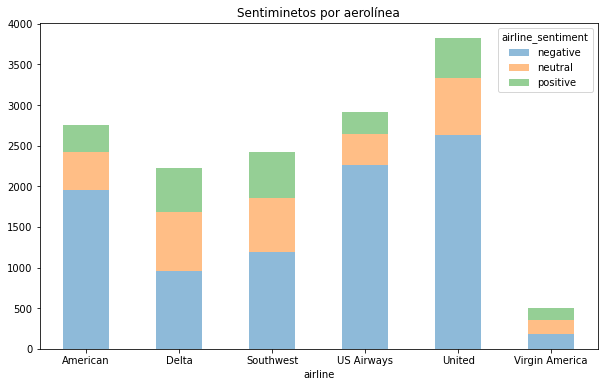

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score

In [9]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})
#print(tweets['airline_sentiment'])
#print(y)

In [10]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

--------------------------------------------
Antes de Balancear:
-1    6093
 0    2115
 1    1600
Name: airline_sentiment, dtype: int64


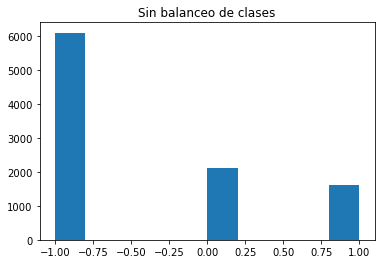

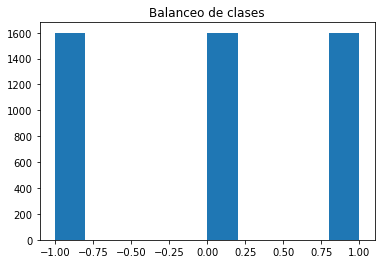

<class 'numpy.ndarray'>
(4800,)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
(4800,)
(9808,)


In [24]:
from sklearn.utils import resample,shuffle
#Balanceo de clases: Downsampling 
print('--------------------------------------------')
print('Antes de Balancear:')
print(y_train.value_counts())

plt.hist(y_train) 
plt.title("Sin balanceo de clases") 
plt.show()

#Aplicación de balanceo de las clases, downsampling 
Xusm1, yusm1 = resample(
                X_train[y_train == -1], 
                y_train[y_train == -1],
                n_samples=len(y_train[y_train == 1]),
                replace=True, random_state=123)

Xus0, yus0 = resample(
                X_train[y_train == 0], 
                y_train[y_train == 0],
                n_samples=len(y_train[y_train == 1]),
                replace=True, random_state=123)

#Union de todos los df
X_train_us = np.vstack((X_train[y_train == 1], Xusm1, Xus0))
y_train_us = np.hstack((y_train[y_train == 1], yusm1, yus0))

plt.hist(y_train_us) 
plt.title("Balanceo de clases") 
plt.show()

#Adecuación de datos para que pueda recivirlos en countvectorizer
X_train_us.shape
print(type(X_train_us))
X_trainflat = X_train_us.flatten()
print(X_trainflat.shape)
print(type(X_trainflat))
X_trainflat1 = pd.Series(data=X_trainflat)
print(type(X_trainflat1))
print(X_trainflat1.shape)
print(y_train.shape)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [12]:
# Celda 1
vect = CountVectorizer(min_df=3,lowercase=True)
X_train_limpio_vectorizd = vect.fit_transform(X_trainflat1)
print(X_train_limpio_vectorizd.shape)
print(vect.get_feature_names()[-150:-100])
print(y_train.shape)

RFR=RandomForestClassifier(max_depth=3,random_state=0)
RFR.fit(X_train_limpio_vectorizd,y_train_us)

X_test_limpio_vectorizd = vect.transform(X_test)
predicciones= RFR.predict(X_test_limpio_vectorizd)
print(predicciones)
Accuracy_non_stwords= accuracy_score(y_test, predicciones)
print(Accuracy_non_stwords)


(4800, 2360)
['using', 'usually', 'utah', 'va', 'vacation', 'value', 've', 'vegas', 'velourlive', 'very', 'via', 'video', 'view', 'vinylvegas', 'virgin', 'virginamerica', 'visit', 'voice', 'volume', 'volunteer', 'voucher', 'vouchers', 'vs', 'vx', 'wait', 'waited', 'waiting', 'walk', 'walked', 'walking', 'wall', 'wanna', 'want', 'wanted', 'wants', 'warm', 'warmth', 'was', 'washington', 'wasn', 'waste', 'wasted', 'watch', 'watched', 'watching', 'water', 'waterbury', 'wave', 'way', 'ways']
(9808,)
[ 1 -1 -1 ... -1  0 -1]
0.6951572847682119


### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [13]:
# Celda 2

vect = CountVectorizer(min_df=3,lowercase=True,stop_words='english')
X_train_limpio_vectorizd = vect.fit_transform(X_trainflat1)
print(X_train_limpio_vectorizd.shape)
print(vect.get_feature_names()[-150:-100])
print(y_train.shape)

RFR=RandomForestClassifier(max_depth=3,random_state=0)
RFR.fit(X_train_limpio_vectorizd,y_train_us)

X_test_limpio_vectorizd = vect.transform(X_test)
predicciones= RFR.predict(X_test_limpio_vectorizd)
print(predicciones)
Accuracy_stwords= accuracy_score(y_test, predicciones)
print(Accuracy_stwords)


(4800, 2137)
['unavailable', 'unbelievable', 'understand', 'understood', 'unfortunately', 'unhappy', 'unhelpful', 'united', 'unitedairlines', 'unlike', 'upcoming', 'update', 'updated', 'updates', 'upgrade', 'upgraded', 'upgrades', 'upset', 'ur', 'us1562', 'usa', 'usair', 'usairways', 'use', 'used', 'useless', 'using', 'usually', 'utah', 'va', 'vacation', 'value', 've', 'vegas', 'velourlive', 'video', 'view', 'vinylvegas', 'virgin', 'virginamerica', 'visit', 'voice', 'volume', 'volunteer', 'voucher', 'vouchers', 'vs', 'vx', 'wait', 'waited']
(9808,)
[ 1 -1 -1 ... -1  0 -1]
0.6324503311258278


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [18]:
# Celda 3
from nltk.stem import WordNetLemmatizer
import nltk
vect = CountVectorizer()
vect.fit(X)
words = list(vect.vocabulary_.keys())[:100]
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
print([wordnet_lemmatizer.lemmatize(word,pos='v') for word in words])
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

['virginamerica', 'what', 'dhepburn', 'say', 'plus', 'you', 've', 'add', 'commercials', 'to', 'the', 'experience', 'tacky', 'didn', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip', 'it', 'really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'in', 'your', 'guests', 'face', 'amp', 'they', 'have', 'little', 'recourse', 'and', 'big', 'bad', 'thing', 'about', 'seriously', 'would', 'pay', '30', 'flight', 'for', 'seat', 'that', 'this', 'play', 'only', 'fly', 'va', 'yes', 'nearly', 'every', 'time', 'fly', 'vx', 'ear', 'worm', 'win', 'go', 'away', 'miss', 'prime', 'opportunity', 'men', 'without', 'hat', 'parody', 'there', 'https', 'co', 'mwpg7grezp', 'well', 'but', 'now', 'do', 'be', 'amaze', 'arrive', 'an', 'hour', 'early', 're', 'too', 'good', 'me', 'do', 'know', 'suicide', 'be', 'second', 'lead', 'cause', 'of', 'death', 'among']


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hfabi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
vect_lemas = CountVectorizer(analyzer=split_into_lemmas)
X_train_l = vect_lemas.fit(X_trainflat1)
X_train_l1 = X_train_l.transform(X_trainflat1)
print(vect_lemas.get_feature_names()[-150:-100])

RFR1 = RandomForestClassifier()
# Train the model on training data
RFR1.fit(X_train_l1, y_train_us)
X_l1= X_train_l.transform(X_test)
predict= RFR1.predict(X_l1)
Accuracy_lemma= accuracy_score(y_test, predict)
print('Accuracy Lemmatizer:')
print(Accuracy_lemma)

['yummy!', 'yup', 'yup!', 'yup.', 'yvonne', 'yvr', 'yvr.', 'yyc', 'yyz', 'y’all', 'z1', 'zabsonre', 'zero', 'zone', '{', '|', '~', '~50k', '£130', '\u200b', '–', '—', '—&gt;', '“@americanair:', '“@jetblue:', '“@southwestair:', '“@southwestair:southwest', '“@united:', '“@usairways:', '“@virginamerica:', '“ear', '“only”', '…', '……..', '€600', '€67', '↔️', '☕✈👍', '☺️', '☺️👍', '☺👍👍', '♥', '♥️', '⛄️☀️', '✈', '✈️', '✈️🌞', '✈️😃👍', '✔️', '❄️❄️']
Accuracy Lemmatizer:
0.7166804635761589


### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [45]:
vect1 = CountVectorizer(lowercase=True,stop_words='english')
vect1.fit(X)
words = list(vect1.vocabulary_.keys())[:100]
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
print([wordnet_lemmatizer.lemmatize(word,pos='v') for word in words])
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

vect_lemas1 = CountVectorizer(analyzer=split_into_lemmas, lowercase=True, stop_words='english')
X_train_l2 = vect_lemas1.fit(X_trainflat1)
X_train_l22 = X_train_l2.transform(X_trainflat1)
print(vect_lemas.get_feature_names()[-150:-100])

RFR1 = RandomForestClassifier()
# Train the model on training data
RFR1.fit(X_train_l22, y_train_us)
X_l2= X_train_l2.transform(X_test)
predict1= RFR1.predict(X_l2)
Accuracy_lemma1= accuracy_score(y_test, predict1)
print('Accuracy Lemmatizer stop:')
print(Accuracy_lemma1)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hfabi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['virginamerica', 'dhepburn', 'say', 'plus', 've', 'add', 'commercials', 'experience', 'tacky', 'didn', 'today', 'mean', 'need', 'trip', 'really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guests', 'face', 'amp', 'little', 'recourse', 'big', 'bad', 'thing', 'seriously', 'pay', '30', 'flight', 'seat', 'play', 'fly', 'va', 'yes', 'nearly', 'time', 'fly', 'vx', 'ear', 'worm', 'win', 'away', 'miss', 'prime', 'opportunity', 'men', 'hat', 'parody', 'https', 'mwpg7grezp', 'amaze', 'arrive', 'hour', 'early', 'good', 'do', 'know', 'suicide', 'second', 'lead', 'cause', 'death', 'teens', '10', '24', 'lt', 'pretty', 'graphics', 'better', 'minimal', 'iconography', 'great', 'deal', 'think', '2nd', 'australia', 'haven', 'go', '1st', 'virginmedia', 'fabulous', 'seductive', 'sky', 'stress', 'travel', 'http', 'ahlxhhkiyn', 'thank', 'sfo', 'pdx', 'schedule', 'mia', 'excite', 'cross', 'country', 'lax', 'mco', 'hear']
[]
Accuracy Lemmatizer stop:
0.7204056291390728


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

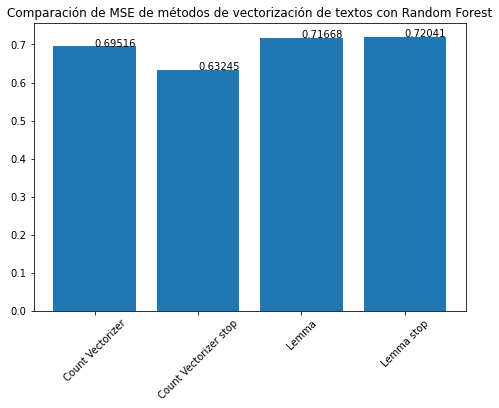

In [46]:
# Celda 5
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de MSE de métodos de vectorización de textos con Random Forest")
ejeX = ['Count Vectorizer','Count Vectorizer stop', 'Lemma','Lemma stop']
ejeY = [round(Accuracy_non_stwords,5),round(Accuracy_stwords,5),round(Accuracy_lemma,5),round(Accuracy_lemma1,5)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.show()

El mejor desempeño se obtuvo con el lematizador:

* La ventaja principal del lematizador radica en que convierte muchas conjugaciones de una palabra a su base común y en términos computacionales, dado que los términos ya están lematizados en un diccionario no se requiere la implementación o uso de recursos al momento de realizar la búsqueda.
* Se puede observar que el accuracy mejora para los dos casos en los que se utilizar el lemmatizer, especialmente cuando se combina el stopwords.

El peor desempeño se obtuvo con el countvectorizer con stopwords y allí la principale desventaja frente al de mejor desempeño, por un lado es que no simplifica en lemas las palabras. Es curioso que en el caso de countvectorizer sin lemas, la opción quitar stopwords no mejoró la predicción mientras al usas los lemas el stopwords si la mejoró.